# add bench to valid 2 (really, just testing two more stuffs)

In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_sroy_gt
import scanpy as sc
from grnndata import GRNAnnData, read_h5ad, from_anndata


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3, compute_scenic
from grnndata import utils as grnutils

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
2024-04-22 17:02:05,417:INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-04-22 17:02:05,541:INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-04-22 17:02:05,631:INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-04-22 17:02:05,726:INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-04-22 17:02:05,821:INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-04-22 17:02:06,042:INFO - Downloading data from `https://omnipathdb.org/about?format=text`
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/arboreto/core.py:12: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask D

In [122]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt', precpt_gene_emb = '../../data/main/gene_embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

In [2]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
res = {}

## do all GRNs

In [7]:
preadata = get_sroy_gt(get="chen", species="human", gt="chip")
adata = preprocessor(preadata.copy())

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 385 renamining
filtered out 0 cells, 385 renamining
Removed 0 genes.
startin QC
Seeing 38 outliers (9.87% of total dataset):
done


In [36]:
adata.var["isTF"]=False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"]=True

/tmp/ipykernel_675826/2862731427.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


number of expressed genes in this cell type: 14620


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


pred shape (4, 3964, 96)
true elem 52 ...
doing regression....


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:345: RuntimeWarning: invalid value encountered in long_scalars
  "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),


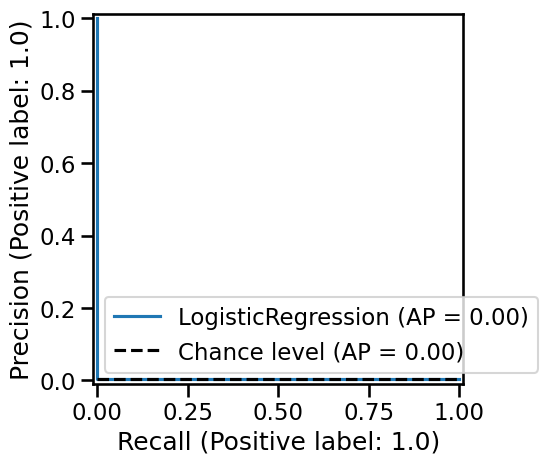

In [37]:
grn_inferer = GRNfer(model, adata,
    how="most var within",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=4000,
    max_cells=64,
    doplot=False,
    batch_size=32,
)
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn, m = train_classifier(grn, other=preadata, C=0.4, class_weight={1:100,0:1}, max_iter=4_000, train_size=0.4, return_full=False)

In [38]:
print(m)

{'used_heads': 0, 'precision': nan, 'random_precision': 0.003153247845280639, 'recall': 0.0, 'random_recall': 0.0, 'predicted_true': 0.0, 'number_of_true': 30.0, 'epr': 0.0}



pred shape (4, 3964, 96)
true elem 52 ...
doing regression....


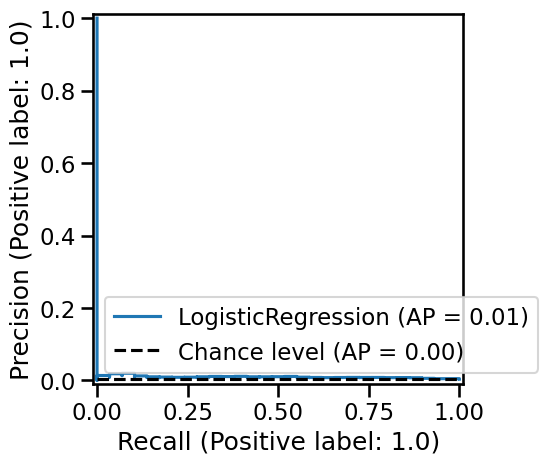

In [5]:
grn, m = train_classifier(grn, other=preadata, C=10, class_weight={1:200,0:1}, max_iter=4_000, train_size=0.5, return_full=False)

In [6]:
m

{'used_heads': 11,
 'precision': 0.01078894133513149,
 'random_precision': 0.0036579212916246218,
 'recall': 0.5517241379310345,
 'random_recall': 0.187058526740666,
 'predicted_true': 1483.0,
 'number_of_true': 29.0,
 'epr': 0.0}

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 161.72 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


(44, 14481) Chd2          3.0
Cnot3         1.0
Ctcf          6.0
Dmap1         4.0
E2f1          4.0
E2f4          3.0
Eed           1.0
Ep300         2.0
Esrrb       794.0
Gli1          1.0
Hcfc1         6.0
Jarid2      273.0
Kat5          1.0
Kdm5a         3.0
Klf2          1.0
Klf4       1481.0
Klf5          3.0
Mafk          3.0
Max           3.0
Myc         260.0
Mycn         47.0
Nanog       899.0
Nr0b1        75.0
Polr2a        5.0
Rest         43.0
Rnf2          1.0
Sall4       178.0
Setdb1      138.0
Smad1         3.0
Sox17        41.0
Sox2       1132.0
Stat3        31.0
Suz12       288.0
Tbx3         62.0
Tcf3       1286.0
Tfcp2l1      54.0
Trim28        8.0
Yy1           1.0
Zc3h11a       1.0
Zfp281       40.0
Zfp384        4.0
Zfp42        15.0
Zfx          23.0
Zic3          1.0
dtype: float64
precision:  0.010815015235489063 
recall:  0.5827915340987688 
random recall: 0.6114248493219487 
random precision: 0.011346371170266198


100%|██████████| 49/49 [00:00<00:00, 132.45it/s]


Area Under Precision-Recall Curve (AUPRC):  0.008219706650232843
overal increase: (mean, max) (0.0021406693110072933, 0.024819141134065803)


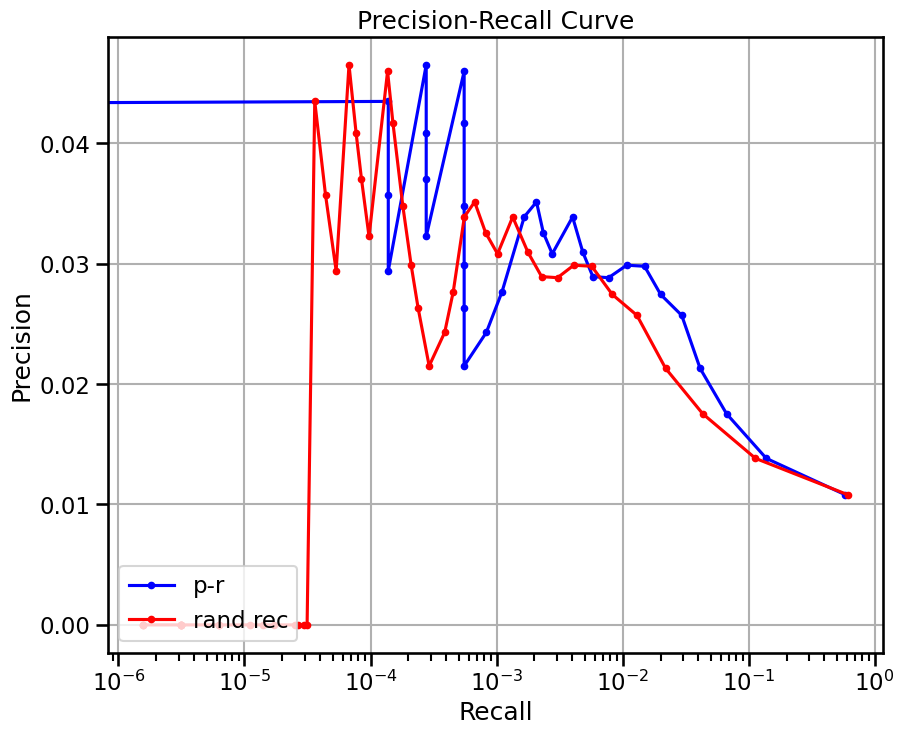

{'precision': 0.010815015235489063,
 'recall': 0.5827915340987688,
 'rand_recall': 0.6114248493219487,
 'rand_precision': 0.011346371170266198,
 'auprc': 0.008219706650232843,
 'pr_increase_to_random': (0.0021406693110072933, 0.024819141134065803),
 'true_positive': 189,
 'true_negative': 622851,
 'false_positive': 7040,
 'false_negative': 7040,
 'EPR': 2.3752025560111054}

In [39]:
genie_grn = compute_genie3(adata[:128], nthreads=32, regulators=adata.var[adata.var.isTF].index.tolist())
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 32 threads
Elapsed time: 341.90 seconds


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=32>
  _warn(f"unclosed running multiprocessing pool {self!r}",


(44, 14481) Chd2          3.0
Cnot3         1.0
Ctcf          6.0
Dmap1         4.0
E2f1          4.0
E2f4          3.0
Eed           1.0
Ep300         2.0
Esrrb       794.0
Gli1          1.0
Hcfc1         6.0
Jarid2      273.0
Kat5          1.0
Kdm5a         3.0
Klf2          1.0
Klf4       1481.0
Klf5          3.0
Mafk          3.0
Max           3.0
Myc         260.0
Mycn         47.0
Nanog       899.0
Nr0b1        75.0
Polr2a        5.0
Rest         43.0
Rnf2          1.0
Sall4       178.0
Setdb1      138.0
Smad1         3.0
Sox17        41.0
Sox2       1132.0
Stat3        31.0
Suz12       288.0
Tbx3         62.0
Tcf3       1286.0
Tfcp2l1      54.0
Trim28        8.0
Yy1           1.0
Zc3h11a       1.0
Zfp281       40.0
Zfp384        4.0
Zfp42        15.0
Zfx          23.0
Zic3          1.0
dtype: float64
precision:  0.009050643864855682 
recall:  0.19532438788214138 
random recall: 0.24486909844299348 
random precision: 0.011346371170266198


100%|██████████| 49/49 [00:00<00:00, 165.34it/s]


Area Under Precision-Recall Curve (AUPRC):  0.002492550074156153
overal increase: (mean, max) (-0.0001594002187461508, 0.006442716676906642)


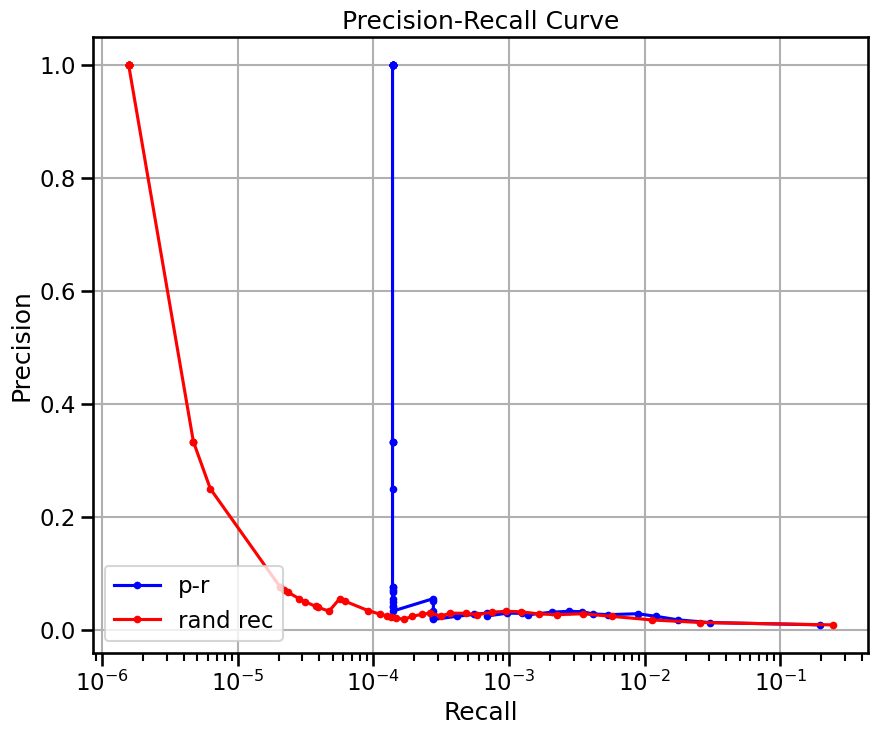

{'precision': 0.009050643864855682,
 'recall': 0.19532438788214138,
 'rand_recall': 0.24486909844299348,
 'rand_precision': 0.011346371170266198,
 'auprc': 0.002492550074156153,
 'pr_increase_to_random': (-0.0001594002187461508, 0.006442716676906642),
 'true_positive': 128,
 'true_negative': 622790,
 'false_positive': 7101,
 'false_negative': 7101,
 'EPR': 1.5809297602950614}

In [44]:
genie_grn = compute_genie3(adata[:128], nthreads=32)#regulators=adata.var[adata.var.isTF].index.tolist())
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [12]:
del grn

In [41]:
grn.write_h5ad("grn_sroy_human_duren.h5ad")

In [104]:
grn = read_h5ad("grn_sroy_human.h5ad")

In [40]:
genie_grn.write_h5ad("grn_sroy_duren_human_genie3.h5ad")

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


In [62]:
genie_grn= read_h5ad("grn_sroy_human_genie3_allgenes.h5ad")

In [9]:
genie_grn.write_h5ad("grn_sroy_human_liu_genie3_allgenes.h5ad")

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


(19, 7845) ATF3        33.0
CTBP2       26.0
EED          1.0
JARID2      77.0
JUN        181.0
MYC        250.0
MYCN        26.0
POU5F1    1026.0
PRDM14     120.0
REST        21.0
SALL4       79.0
SETDB1      67.0
STAT3       12.0
SUZ12      189.0
TCF3       703.0
TRIM28       3.0
ZFP42        7.0
ZIC3         1.0
ZNF281      27.0
dtype: float64
precision:  0.016379457430472616 
recall:  0.06739206739206739 
random recall: 0.07865213773853297 
random precision: 0.019116186693147963


100%|██████████| 49/49 [00:00<00:00, 628.70it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0009377317760709684
overal increase: (mean, max) (-0.0005213209185403822, -6.709788239083174e-06)


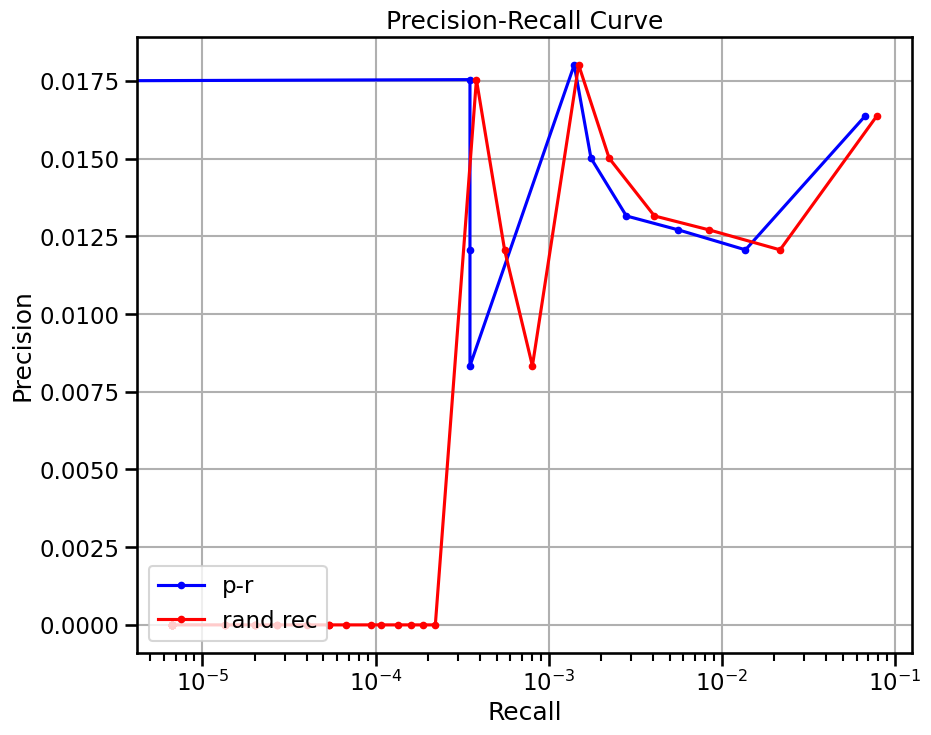

{'precision': 0.016379457430472616,
 'recall': 0.06739206739206739,
 'rand_recall': 0.07865213773853297,
 'rand_precision': 0.019116186693147963,
 'auprc': 0.0009377317760709684,
 'pr_increase_to_random': (-0.0005213209185403822, -6.709788239083174e-06),
 'true_positive': 39,
 'true_negative': 143377,
 'false_positive': 2810,
 'false_negative': 2810,
 'EPR': 0.7081601043553146}

In [70]:
BenGRN(genie_grn, do_auc=True, doplot=True).compare_to(other=preadata)

# comparing on same function and making sure that the function makes sense

In [17]:
grn.var.index = grn.var['symbol']

pred shape (15, 2481, 96)
true elem 12047 ...
doing regression....


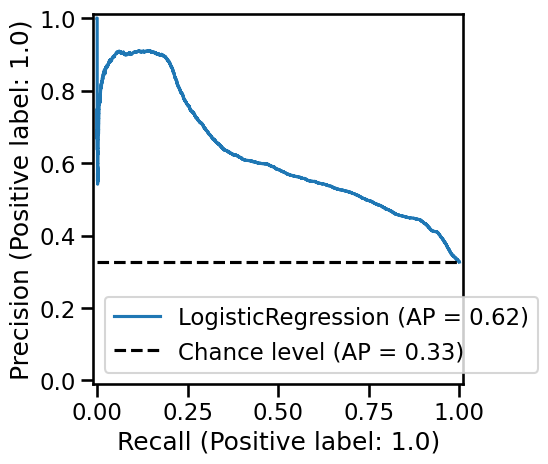

{'used_heads': 11,
 'precision': 0.8755122950819673,
 'random_precision': 0.3268588537868028,
 'recall': 0.2007046388725778,
 'random_recall': 0.07492994510767341,
 'predicted_true': 1952.0,
 'number_of_true': 8515.0,
 'epr': 4.694236704653371}

In [114]:
grn, m = train_classifier(grn, other=preadata, C=10, class_weight={1:1,0:1}, max_iter=4_000, train_size=0.3, return_full=True, shuffle=True)
m

In [110]:
preadata.grn[preadata.grn.sum(1)>1].sum(1)

ATF2      2438.0
ATF3      3030.0
BACH1     4477.0
BCL11A     410.0
BRCA1     1634.0
CBX5        26.0
CHD1      5394.0
CHD2      4852.0
CHD7      1542.0
CTBP2     2795.0
CTCF      6972.0
DMAP1     1106.0
E2F1      2690.0
E2F4      3190.0
EED        177.0
EGR1      5083.0
EP300     5030.0
EZH2       837.0
GABPA     3949.0
GLI1        31.0
GTF2F1    3413.0
HDAC2     6796.0
JARID2     356.0
JUN       1122.0
KAT2A      159.0
KAT5       436.0
KDM1A     3988.0
KDM5A     3570.0
MAFK      2391.0
MAX       5076.0
MXI1      3369.0
MYC       5446.0
MYCN      1527.0
PHC1       269.0
PHF8      7674.0
POLR2A    7899.0
POU5F1    3375.0
PRDM14     884.0
RAD21     7008.0
REST      4720.0
RFX5       965.0
SALL4      521.0
SETDB1    1715.0
SIN3A     7744.0
SP1       6118.0
SRF       2768.0
STAT3      648.0
SUZ12     2666.0
TAF1      7978.0
TAF7      6589.0
TCF12     3673.0
TCF3      1771.0
TRIM28    1640.0
USF2      3419.0
YY1       6737.0
ZFP42      804.0
ZIC3       169.0
ZNF143    6322.0
ZNF274     126

In [115]:
grn.varp['GRN'] = grn.varp['classified']

In [56]:
grn.varp["GRN"][grn.grn>0.5]=1

In [116]:
grn.var.index = grn.var['symbol'] 

(15, 2481) BACH1     1343.0
CBX5         8.0
EP300     1513.0
KDM5A     1141.0
MXI1      1016.0
POU5F1    1054.0
PRDM14     300.0
REST      1465.0
SALL4      173.0
SIN3A     2312.0
STAT3      203.0
TCF12     1099.0
ZFP42      260.0
ZIC3        62.0
ZNF281      98.0
dtype: float64
precision:  0.32371355636168214 
recall:  1.0 
random recall: 1.0004032258064517 
random precision: 0.3238440860215054


100%|██████████| 49/49 [00:01<00:00, 35.57it/s]


Area Under Precision-Recall Curve (AUPRC):  0.6206308629194841
overal increase: (mean, max) (0.10605050496665834, 0.25827491295294147)


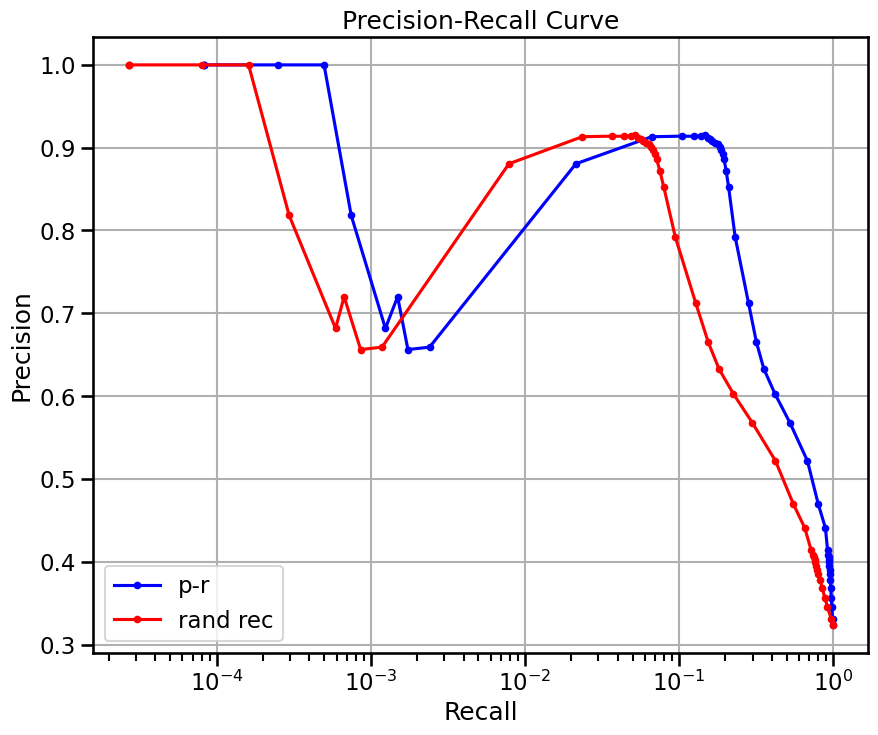

{'precision': 0.32371355636168214,
 'recall': 1.0,
 'rand_recall': 1.0004032258064517,
 'rand_precision': 0.3238440860215054,
 'auprc': 0.6206308629194841,
 'pr_increase_to_random': (0.10605050496665834, 0.25827491295294147),
 'true_positive': 6714,
 'true_negative': 19820,
 'false_positive': 5333,
 'false_negative': 5333,
 'EPR': 4.678879060355673}

In [117]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(preadata)

base enrichment
Top central genes: []


2024-04-22 17:37:30,445 [WARNING] Duplicated values found in preranked stats: 99.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


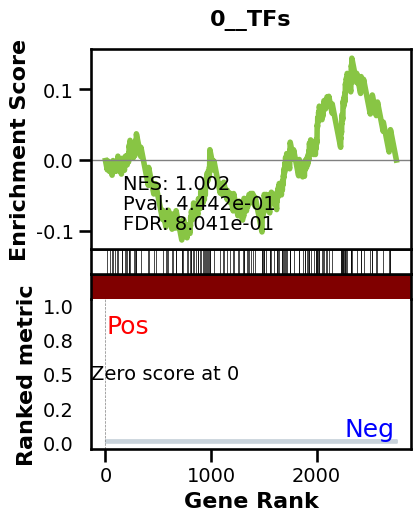

2024-04-22 17:37:31,224 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


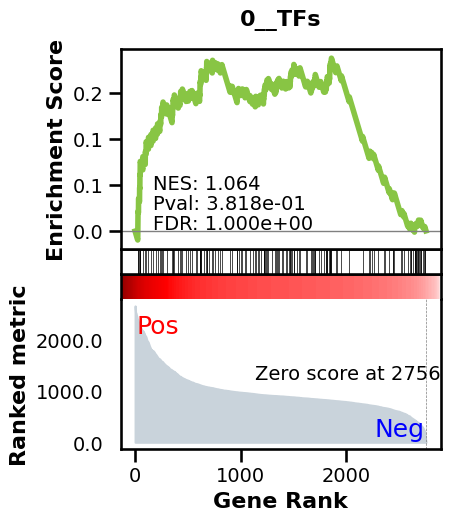

2024-04-22 17:37:33,817 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['celltype.gmt__Plasmacytoid Dendritic cells', 'celltype.gmt__Myeloid Dendritic cells', 'celltype.gmt__Naive B cells', 'celltype.gmt__Plasma B cells', 'celltype.gmt__Memory B cells', 'celltype.gmt__Acinar cells', 'celltype.gmt__Melanocytes']


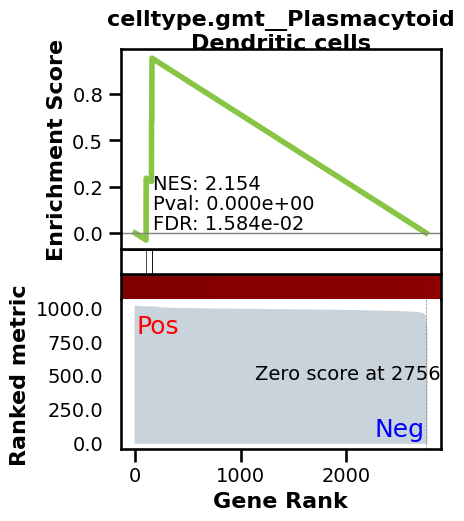

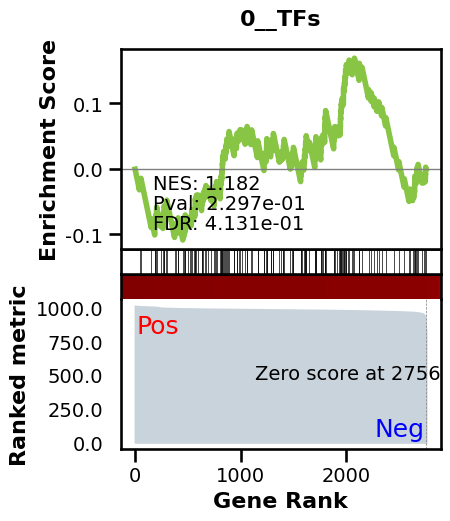

_________________________________________
TF specific enrichment


2024-04-22 17:37:35,485:INFO - Downloading and generating Enrichr library gene sets...
2024-04-22 17:37:35,487:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-22 17:37:35,708:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-22 17:37:35,718 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__FOS
0    1.998966
Name: NES, dtype: object




2024-04-22 17:37:35,922 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 17:37:36,150 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 17:37:36,355 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__FOS
0    3.180497
Name: NES, dtype: object




2024-04-22 17:37:36,580 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 17:37:36,801 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 17:37:37,014 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__FOS
0    2.147926
Name: NES, dtype: object




2024-04-22 17:37:37,247 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__FOS
0    1.684715
Name: NES, dtype: object




2024-04-22 17:37:37,486 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 17:37:37,716 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 17:37:37,937 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 17:37:38,170 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 17:37:38,384 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 17:37:38,595 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 17:37:38,813 [WARNING] Duplicated values found in preranked stats: 0.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__TCF12
0    2.509498
Name: NES, dtype: object


found some significant results for  33.333333333333336 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1863 genes
intersection pct: 0.675734494015234
precision:  0.0028350724480968857 
recall:  1.0 
random recall: 1.000919963201472 
random precision: 0.002837680610422642


100%|██████████| 49/49 [00:30<00:00,  1.63it/s]


Area Under Precision-Recall Curve (AUPRC):  0.003268660237317932
overal increase: (mean, max) (0.02188123106079052, 0.08185227238425008)


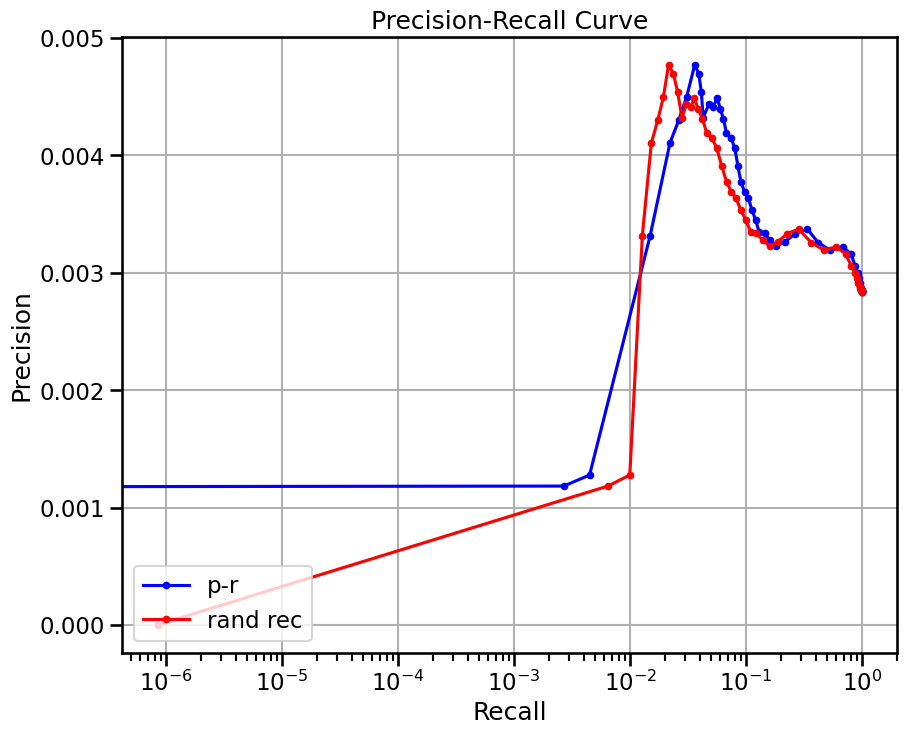

{'enriched_terms_Regulators': ['celltype.gmt__Plasmacytoid Dendritic cells',
  'celltype.gmt__Myeloid Dendritic cells',
  'celltype.gmt__Naive B cells',
  'celltype.gmt__Plasma B cells',
  'celltype.gmt__Memory B cells',
  'celltype.gmt__Acinar cells',
  'celltype.gmt__Melanocytes'],
 'significant_enriched_TFtargets': 33.333333333333336,
 'precision': 0.0028350724480968857,
 'recall': 1.0,
 'rand_recall': 1.000919963201472,
 'rand_precision': 0.002837680610422642,
 'auprc': 0.003268660237317932,
 'pr_increase_to_random': (0.02188123106079052, 0.08185227238425008),
 'true_positive': 2,
 'true_negative': 1175946,
 'false_positive': 3354,
 'false_negative': 3354,
 'EPR': 0.2090697781091757}

In [119]:
BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark(base_pr_threshold=0.4)

(15, 2481) BACH1     1343.0
CBX5         8.0
EP300     1513.0
KDM5A     1141.0
MXI1      1016.0
POU5F1    1054.0
PRDM14     300.0
REST      1465.0
SALL4      173.0
SIN3A     2312.0
STAT3      203.0
TCF12     1099.0
ZFP42      260.0
ZIC3        62.0
ZNF281      98.0
dtype: float64
precision:  0.32371355636168214 
recall:  1.0 
random recall: 1.0 
random precision: 0.32371355636168214


100%|██████████| 49/49 [00:01<00:00, 35.12it/s]


Area Under Precision-Recall Curve (AUPRC):  0.6220283162752778
overal increase: (mean, max) (0.10676013586046348, 0.25967091964729794)


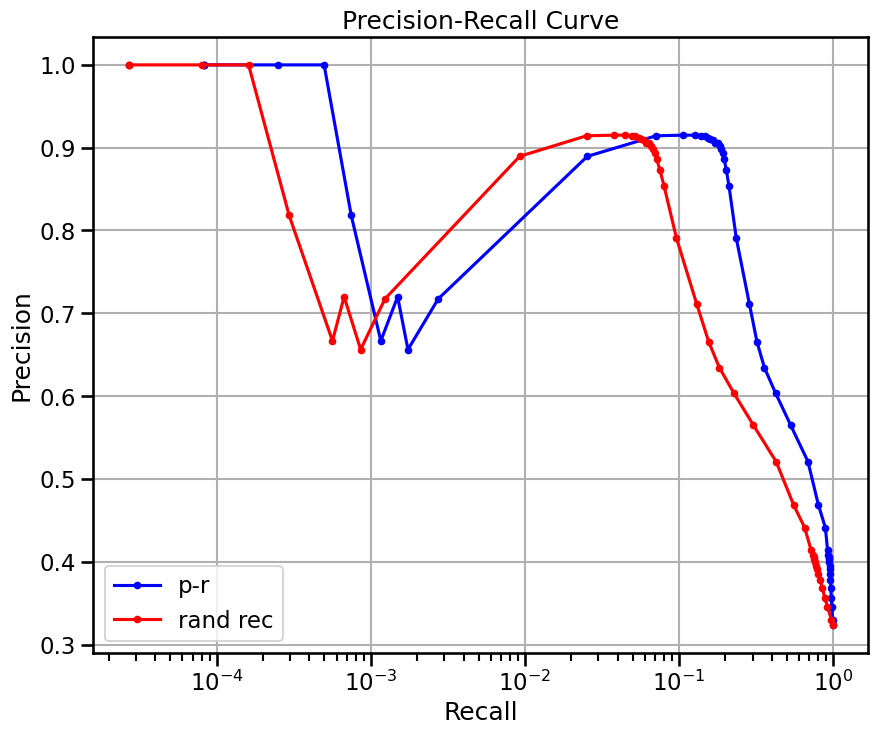

{'precision': 0.32371355636168214,
 'recall': 1.0,
 'rand_recall': 1.0,
 'rand_precision': 0.32371355636168214,
 'auprc': 0.6220283162752778,
 'pr_increase_to_random': (0.10676013586046348, 0.25967091964729794),
 'true_positive': 6719,
 'true_negative': 19840,
 'false_positive': 5328,
 'false_negative': 5328,
 'EPR': 4.695889583276971}

In [16]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## just testing if we can make predictions per regulon

In [72]:
elems = preadata.var[preadata.grn.sum(1) != 0].index.tolist()
sub = preadata.get(grn.var["symbol"].tolist()).get(elems).targets

genes = grn.var["symbol"].tolist()
args = np.argsort(genes)


In [89]:
sorted_genes = np.array(genes)[args]
adj = grn.varp["GRN"][args, :, :][:, args, :][np.isin(sorted_genes, sub.index.values)][
    :, np.isin(sorted_genes, sub.columns.values)
]
print("pred shape", adj.shape, )
da = sub.values

print("true elem", int(da[1:].sum()), "...")
da = da[:1].flatten()
adj = adj[:1].reshape(-1, adj.shape[-1])

pred shape (8, 2481, 96)
true elem 100 ...
 (8, 2481, 96)
true elem 100 ...


In [88]:
sub.sum(1)

POU5F1    349.0
PRDM14     46.0
REST        6.0
SALL4      28.0
STAT3       6.0
ZFP42       3.0
ZIC3        1.0
ZNF281     10.0
dtype: float64

doing regression....


/tmp/ipykernel_664579/1653846945.py:17: RuntimeWarning: invalid value encountered in long_scalars
  "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),


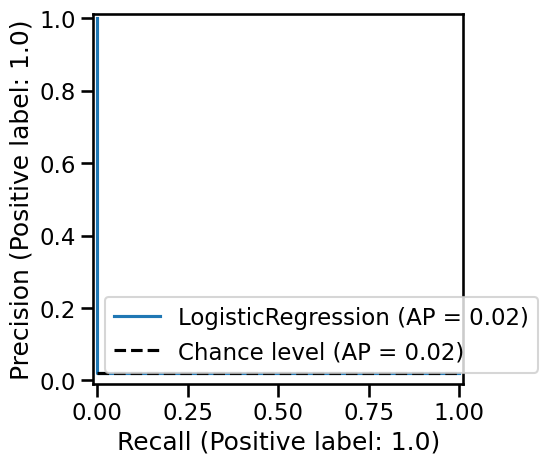

{'used_heads': 0, 'precision': nan, 'random_precision': 0.019339242546333603, 'recall': 0.0, 'random_recall': 0.0, 'predicted_true': 0.0, 'number_of_true': 24.0}



In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    adj, da, random_state=0, train_size=0.5, shuffle=False
)
print("doing regression....")
clf = LogisticRegression(
    penalty="l1",
    C=2,
    solver="liblinear",
    class_weight={1:1,0:1},
    max_iter=4_000,
    n_jobs=8,
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
metrics = {
    "used_heads": (clf.coef_ != 0).sum(),
    "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),
    "random_precision": y_test.sum() / len(y_test),
    "recall": (pred[y_test == 1] == 1).sum() / y_test.sum(),
    "random_recall": pred.sum() / len(pred),
    "predicted_true": pred.sum(),
    "number_of_true": y_test.sum(),
}
PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, plot_chance_level=True
)
plt.show()
print(metrics)

In [41]:
grn.varp["classified"] = clf.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]

In [42]:
grn.varp['GRN'] = grn.varp['classified']

In [44]:
grn.var.index = grn.var['symbol']

In [56]:
preadata.varp['GRN'][preadata.varp['GRN'].sum(1)].shape

(35, 8595)

(9, 2481) PRDM14     300.0
REST      1465.0
SALL4      173.0
SIN3A     2312.0
STAT3      203.0
TCF12     1099.0
ZFP42      260.0
ZIC3        62.0
ZNF281      98.0
dtype: float64
precision:  0.2674548793049398 
recall:  1.0 
random recall: 1.0004032258064517 
random precision: 0.2675627240143369


100%|██████████| 49/49 [00:01<00:00, 36.15it/s]


Area Under Precision-Recall Curve (AUPRC):  0.34686548581298426
overal increase: (mean, max) (0.07723069065435592, 0.2652414073321858)


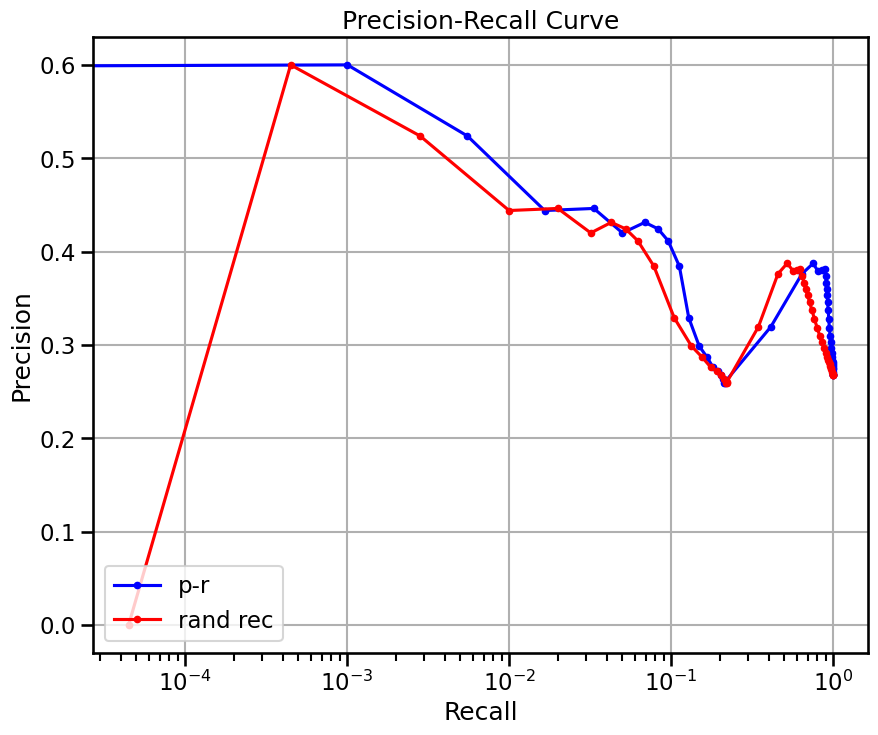

{'precision': 0.2674548793049398,
 'recall': 1.0,
 'rand_recall': 1.0004032258064517,
 'rand_precision': 0.2675627240143369,
 'auprc': 0.34686548581298426,
 'pr_increase_to_random': (0.07723069065435592, 0.2652414073321858),
 'true_positive': 1599,
 'true_negative': 11975,
 'false_positive': 4373,
 'false_negative': 4373,
 'EPR': 1.0013018789968944}

In [61]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [33]:
sorted_genes[:400][(clf.predict(grn.varp["GRN"][args[:400], :, :][:, args[:2000], :].reshape(-1, 96)).reshape(400,2000).sum(1).astype(int)>300)]

array(['AATF', 'ACADM', 'ACAP1', 'ACBD3', 'ACOT7', 'ACTR6', 'ADA',
       'ADIPOR1', 'ADPGK', 'AGPAT1-2', 'AIDA', 'AIFM1', 'AK6', 'ALAD',
       'ALDH3A2', 'ANKRD13D', 'AP5Z1', 'APBB1', 'ARID3A', 'ARL10',
       'ARMC6', 'ARPC1B', 'ATAD3B', 'ATRN', 'B3GALT4', 'BAMBI', 'BPHL',
       'BRD1', 'BRD7', 'BTNL2-2', 'C15orf40', 'C1orf122', 'C1orf52',
       'C6orf15-1', 'C7orf50', 'CASP6', 'CCDC112', 'CCDC115', 'CCDC18',
       'CCDC28B', 'CCDC85B', 'CCNT1', 'CD302', 'CDC23', 'CDC40', 'CDIPT',
       'CDK2', 'CENPO'], dtype='<U10')

# testing on CHIP one vs the rest

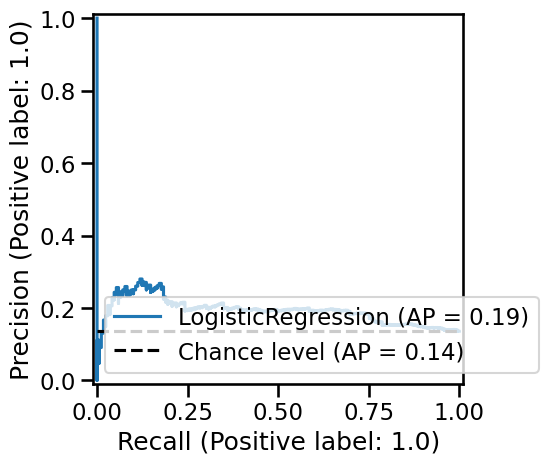

{'used_heads': 4, 'precision': 0.1361804995970991, 'random_precision': 0.1361804995970991, 'recall': 1.0, 'random_recall': 1.0, 'predicted_true': 1241.0, 'number_of_true': 169.0}



In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    adj, da, random_state=0, train_size=0.5, shuffle=True
)
clf = LogisticRegression(
    penalty="l1",
    C=10,
    solver="liblinear",
    class_weight={1:8,0:1},
    max_iter=4_000,
    n_jobs=8,
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
metrics = {
    "used_heads": (clf.coef_ != 0).sum(),
    "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),
    "random_precision": y_test.sum() / len(y_test),
    "recall": (pred[y_test == 1] == 1).sum() / y_test.sum(),
    "random_recall": pred.sum() / len(pred),
    "predicted_true": pred.sum(),
    "number_of_true": y_test.sum(),
}
PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, plot_chance_level=True
)
plt.show()
print(metrics)

In [135]:
compute_epr(clf, X_test, y_test)

1.828358208955224

## looking at full and testing different params

In [83]:
grn_inferer = GRNfer(model, adata,
    how="random expr",
    preprocess="softmax",
    head_agg='none',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=2000,
    max_cells=64,
    doplot=False,
    batch_size=32,
)
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m = train_classifier(grn, other=preadata, C=0.4, class_weight={1:200,0:1}, max_iter=4_000, train_size=0.4, return_full=False)

/tmp/ipykernel_569772/2315311075.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
from anndata.utils import make_index_unique
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))

In [ ]:
elems = preadata.var[preadata.grn.sum(1) != 0].index.tolist()
sub = preadata.get(grn.var["symbol"].tolist()).get(elems).targets

genes = grn.var["symbol"].tolist()
args = np.argsort(genes)


In [ ]:
genes = np.array(genes)[args]
adj = grn.varp["GRN"][args, :, :][:, args, :][np.isin(genes, sub.index.values)][
    :, np.isin(genes, sub.columns.values)
]
print("pred shape", adj.shape)
da = sub.values

pred shape (8, 2481, 96)


doing regression....


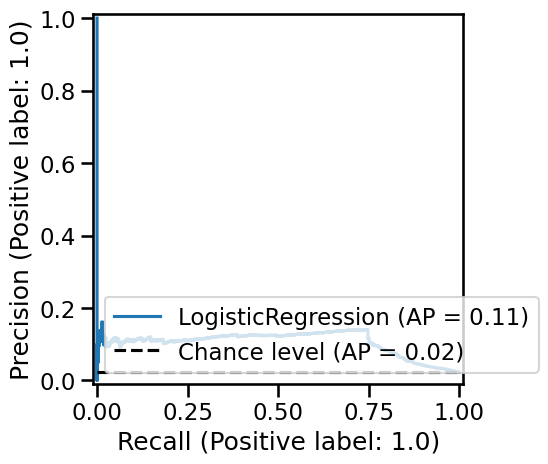

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    adj, da, random_state=0, train_size=0.3
)
print("doing regression....")
clf = LogisticRegression(
    penalty="l1",
    C=0.4,
    solver="liblinear",
    class_weight={1:100,0:1},
    max_iter=4_000,
    n_jobs=8,
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
metrics = {
    "used_heads": (clf.coef_ != 0).sum(),
    "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),
    "random_precision": y_test.sum() / len(y_test),
    "recall": (pred[y_test == 1] == 1).sum() / y_test.sum(),
    "random_recall": pred.sum() / len(pred),
    "predicted_true": pred.sum(),
    "number_of_true": y_test.sum(),
}
PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, plot_chance_level=True
)
plt.show()

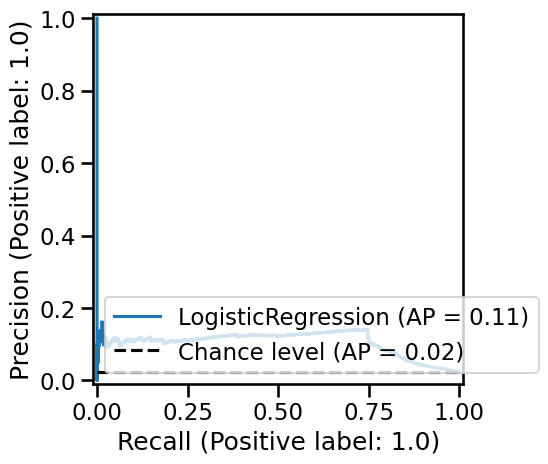

In [ ]:
clf = LogisticRegression(
    penalty="l1",
    C=0.4,
    solver="liblinear",
    class_weight={1:200,0:1},
    max_iter=4_000,
    n_jobs=8,
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
metrics = {
    "used_heads": (clf.coef_ != 0).sum(),
    "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),
    "random_precision": y_test.sum() / len(y_test),
    "recall": (pred[y_test == 1] == 1).sum() / y_test.sum(),
    "random_recall": pred.sum() / len(pred),
    "predicted_true": pred.sum(),
    "number_of_true": y_test.sum(),
}
PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, plot_chance_level=True
)
plt.show()

In [ ]:
metrics

{'used_heads': 2,
 'precision': 0.03317535545023697,
 'random_precision': 0.022815603857780337,
 'recall': 0.9495268138801262,
 'random_recall': 0.6530156902259968,
 'predicted_true': 9073.0,
 'number_of_true': 317.0}

In [ ]:
grn.var[grn.var["symbol"]=="POU5F1"]

,uid,symbol,ncbi_gene_ids,biotype,description,synonyms,organism_id,public_source_id,created_by_id,mt,ribo,hb,organism,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,TFs
ENSG00000229094,5uym5gFaktN7,POU5F1,5460,protein_coding,POU class 5 homeobox 1 [Source:HGNC Symbol;Acc...,OCT4|OCT3/4|OCT3|OCT-4|MGC22487|OTF3,2,9.0,1,False,False,False,NCBITaxon:9606,0,0.0,0.0,100.0,0.0,0.0,True


## marker genes sinkhorn

In [120]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad') 

In [ ]:
adata.var["isTF"]=False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"]=True

In [127]:
grn_inferer = GRNfer(model, adata,
    how="random expr",
    preprocess="softmax",
    head_agg='max',
    filtration="none",
    forward_mode="none",
    organisms=adata.obs['organism_ontology_term_id'][0],
    apc=False,
    symmetrize=False,
    num_genes=2000,
    max_cells=64,
    doplot=False,
    batch_size=32,
)

/tmp/ipykernel_696340/3621298283.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [134]:
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))

base enrichment
Top central genes: []


2024-04-22 18:17:24,349 [WARNING] Duplicated values found in preranked stats: 99.99% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['0__TFs', 'celltype.gmt__Hepatocytes', 'celltype.gmt__Cholangiocytes', 'celltype.gmt__Retinal pigment epithelial cells', 'celltype.gmt__Myoepithelial cells', 'celltype.gmt__Retinal progenitor cells', 'celltype.gmt__Enterocytes', 'celltype.gmt__Embryonic stem cells', 'celltype.gmt__Memory B cells', 'celltype.gmt__Naive B cells']


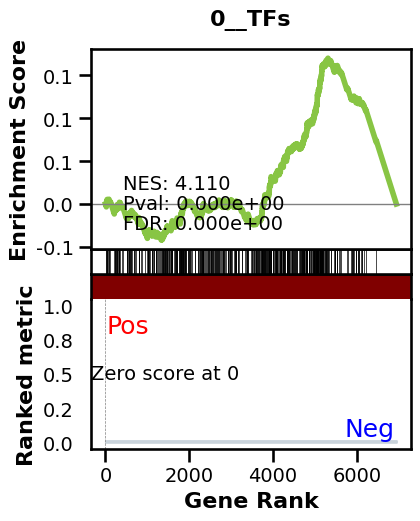

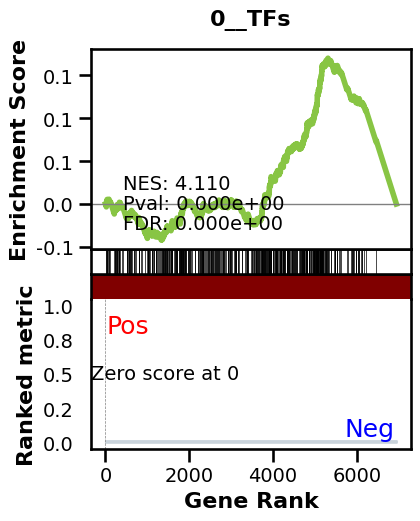

2024-04-22 18:17:28,063 [WARNING] Duplicated values found in preranked stats: 0.26% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['0__TFs']


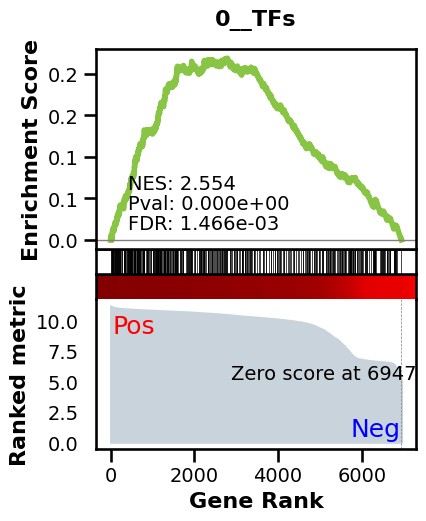

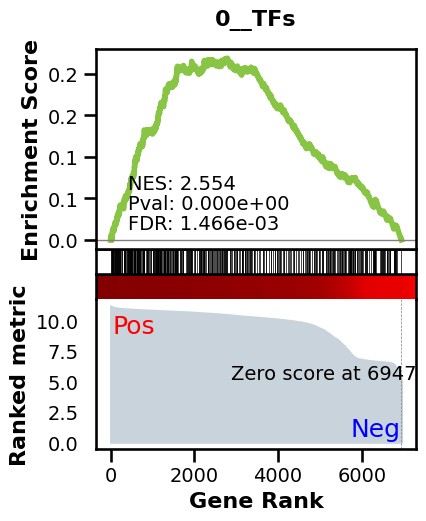

2024-04-22 18:17:31,389 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[]


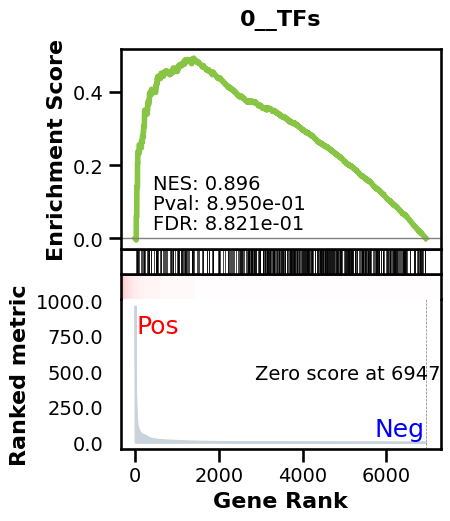

_________________________________________
TF specific enrichment


2024-04-22 18:17:34,730:INFO - Downloading and generating Enrichr library gene sets...
2024-04-22 18:17:34,732:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-04-22 18:17:34,954:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0
2024-04-22 18:17:34,977 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__FOS
0    1.287696
Name: NES, dtype: object




2024-04-22 18:17:35,450 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__NELFE
0    1.450689
Name: NES, dtype: object




2024-04-22 18:17:35,976 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__JUND
0    1.413922
Name: NES, dtype: object




2024-04-22 18:17:36,469 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__FOS
0    1.411967
Name: NES, dtype: object




2024-04-22 18:17:36,984 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:37,477 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:37,943 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__SRF
0    1.231021
Name: NES, dtype: object




2024-04-22 18:17:38,438 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:38,918 [WARNING] Duplicated values found in preranked stats: 0.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:39,408 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__BCL11A
0    1.282473
Name: NES, dtype: object




2024-04-22 18:17:39,918 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__FOS
0    1.370499
Name: NES, dtype: object




2024-04-22 18:17:40,409 [WARNING] Duplicated values found in preranked stats: 0.16% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__PRDM1
0    1.40973
Name: NES, dtype: object




2024-04-22 18:17:40,904 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__SRF
0    1.299124
Name: NES, dtype: object




2024-04-22 18:17:41,416 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:41,895 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:42,362 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__STAT1
0    1.282144
Name: NES, dtype: object




2024-04-22 18:17:42,842 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:43,328 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:43,813 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__SRF
0    1.209068
Name: NES, dtype: object




2024-04-22 18:17:44,313 [WARNING] Duplicated values found in preranked stats: 0.19% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:44,788 [WARNING] Duplicated values found in preranked stats: 0.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:45,235 [WARNING] Duplicated values found in preranked stats: 0.16% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__BCLAF1
0    1.354045
Name: NES, dtype: object




2024-04-22 18:17:45,731 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:46,215 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__RAD21
0    1.238858
Name: NES, dtype: object




2024-04-22 18:17:46,737 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__RAD21
0    1.318662
Name: NES, dtype: object




2024-04-22 18:17:47,224 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__MAX
0    1.349742
Name: NES, dtype: object




2024-04-22 18:17:47,725 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__JUND
0    1.343343
Name: NES, dtype: object




2024-04-22 18:17:48,212 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__MEF2A
0    1.296304
Name: NES, dtype: object




2024-04-22 18:17:48,707 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__TAF7
0    1.279423
Name: NES, dtype: object




2024-04-22 18:17:49,209 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:49,674 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__BCL11A
0    1.406534
Name: NES, dtype: object




2024-04-22 18:17:50,130 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:50,621 [WARNING] Duplicated values found in preranked stats: 0.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:51,126 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


no sig...


2024-04-22 18:17:51,583 [WARNING] Duplicated values found in preranked stats: 0.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


found!  0__STAT1
0    1.292228
Name: NES, dtype: object


found some significant results for  55.55555555555556 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3901 genes
intersection pct: 0.5614565342544617
precision:  0.0016327658932987488 
recall:  1.0 
random recall: 1.0003179650238474 
random precision: 0.0016332850557449487


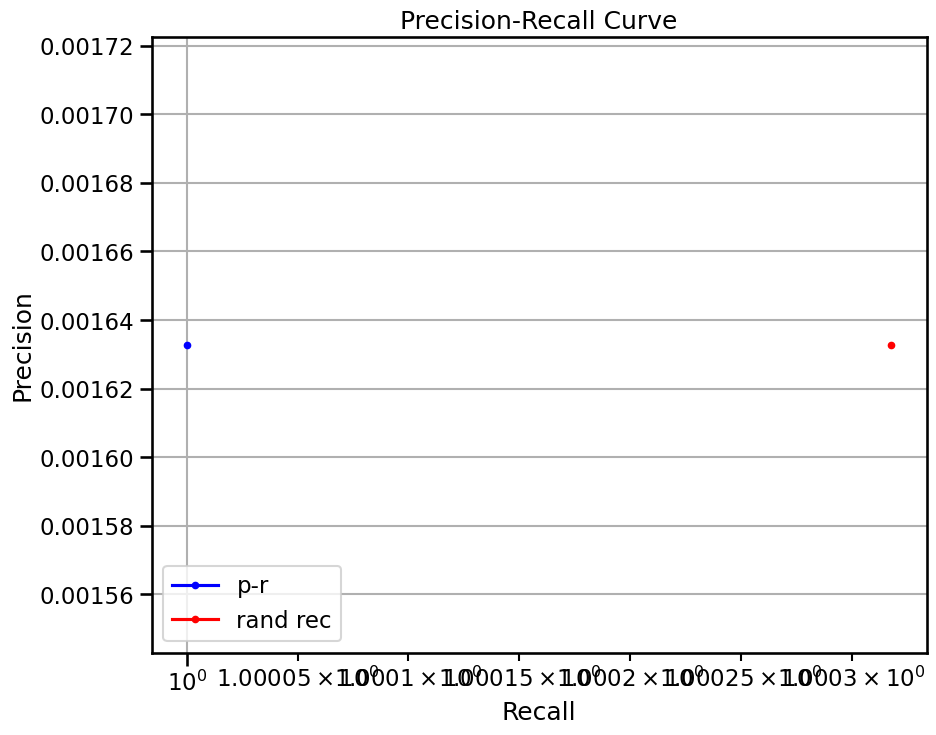

In [135]:
m = BenGRN(grn, do_auc=False).scprint_benchmark()

In [136]:
for celltype in list(set(adata.obs.cell_type))[:]:
    print(celltype)
    print("scprint\n")
    grn = grn_inferer(layer=list(range(model.nlayers))[8:], cell_type=celltype)
    #grn, m = train_classifier(grn, C=0.4)
    #grn.varp['GRN'] = grn.varp['classified']
    #print(m)
    grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
    m = BenGRN(grn, do_auc=False).scprint_benchmark()
    print(m)
    print("genie3 TF only\n")
    subadata = adata[adata.obs.cell_type==celltype, adata.var.index.isin(grn_inferer.curr_genes)]
    grn = compute_genie3(subadata, nthreads=32, regulators=adata.var[adata.var.isTF].index.tolist())
    m = BenGRN(grn).scprint_benchmark()
    print(m)
    print("genie3\n")
    grn = compute_genie3(subadata, nthreads=32)
    m = BenGRN(grn).scprint_benchmark()
    print(m)
    print("______________________________")

kidney loop of Henle thick ascending limb epithelial cell
scprint



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

: 